### Enviroment preparation

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F 
import numpy as np
import pandas as pd
import random
import time as t
import os
import re
import gc
from subprocess import Popen
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
ControlSparkCluster('stop')

cluster stopped


In [2]:
def ControlSparkCluster(action):
    if action == 'start':
        Popen('./start_cluster.sh',shell=True)
        t.sleep(10)
        print 'cluster started'
    elif action == 'stop':
        Popen('./stop_cluster.sh',shell=True)
        sc.stop()
        t.sleep(3)
        print 'cluster stopped'
    else:
        raise Exception('Unsupported command!')

In [3]:
ControlSparkCluster('start')

cluster started


In [4]:
conf = SparkConf().setMaster("spark://cathome:7077").setAppName("bosh")\
.setAll((['spark.executor.cores','4']
        ,['spark.driver.cores','4']
        ,['spark.driver.memory','4g']
        ,['spark.driver.maxResultSize','4g']
        ,['spark.executor.memory','1g']
        ,['spark.python.worker.memory','1g']
        ,['spark.default.parallelism','4']
       ))

In [5]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

### Data preparation

In [6]:
dir_name = '../../../diploma_data'

In [7]:
tr_num_file_name = 'train_numeric.csv'
tr_date_file_name = 'train_date.csv'
tr_cat_file_name = 'train_categorical.csv'

In [8]:
tr_num_data_file = '{0}/{1}'.format(dir_name,tr_num_file_name)
tr_date_data_file = '{0}/{1}'.format(dir_name,tr_date_file_name)
tr_cat_data_file = '{0}/{1}'.format(dir_name,tr_cat_file_name)

In [9]:
%%time
df_num = sqlContext.read.csv(tr_num_data_file, sep=',', header=True, inferSchema=True)
df_date = sqlContext.read.csv(tr_date_data_file, sep=',', header=True, inferSchema=True)
df_cat = sqlContext.read.csv(tr_cat_data_file, sep=',', header=True, inferSchema=True)

CPU times: user 56 ms, sys: 20 ms, total: 76 ms
Wall time: 5min 14s


### Data analisys/Data transformation

In [11]:
df_num2 = df_num
df_date2 = df_date
df_cat2 = df_cat

In [10]:
df_num2.limit(10).toPandas()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,None,None,None,None,None,None,None,None,None,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,None,None,None,None,None,None,None,None,None,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,None,None,None,None,None,None,None,None,None,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,None,None,None,None,None,None,None,None,None,0
5,13,0.003,0.019,0.294,0.312,0.031,0.161,0.022,0.088,-0.005,...,None,None,None,None,None,None,None,None,None,0
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,0
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,0
8,18,-0.016,-0.041,-0.179,-0.179,-0.056,0.161,-0.007,-0.032,-0.082,...,None,None,None,None,None,None,None,None,None,0
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,0


In [11]:
df_date2.limit(10).toPandas()

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,4,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,...,None,None,None,None,None,None,None,None,None,None
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,7,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,...,None,None,None,None,None,None,None,None,None,None
3,9,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,...,None,None,None,None,None,None,None,None,None,None
4,11,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,None,None,None,None,None,None,None,None,None,None
5,13,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,...,None,None,None,None,None,None,None,None,None,None
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
8,18,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,...,None,None,None,None,None,None,None,None,None,None
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [12]:
df_cat2.limit(10).toPandas()

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,6,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,7,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,9,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,11,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,13,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,14,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,16,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,18,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,23,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [14]:
print 'numeric dataset row count: ', df_num2.count()
print 'date dataset row count: ',df_date2.count()
print 'categorical dataset row count: ',df_cat2.count()

numeric dataset row count:  1183747
date dataset row count:  1183747
categorical dataset row count:  1183747


In [16]:
df_num2.printSchema()
df_date2.printSchema()
df_cat2.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- L0_S0_F0: double (nullable = true)
 |-- L0_S0_F2: double (nullable = true)
 |-- L0_S0_F4: double (nullable = true)
 |-- L0_S0_F6: double (nullable = true)
 |-- L0_S0_F8: double (nullable = true)
 |-- L0_S0_F10: double (nullable = true)
 |-- L0_S0_F12: double (nullable = true)
 |-- L0_S0_F14: double (nullable = true)
 |-- L0_S0_F16: double (nullable = true)
 |-- L0_S0_F18: double (nullable = true)
 |-- L0_S0_F20: double (nullable = true)
 |-- L0_S0_F22: double (nullable = true)
 |-- L0_S1_F24: double (nullable = true)
 |-- L0_S1_F28: double (nullable = true)
 |-- L0_S2_F32: double (nullable = true)
 |-- L0_S2_F36: double (nullable = true)
 |-- L0_S2_F40: double (nullable = true)
 |-- L0_S2_F44: double (nullable = true)
 |-- L0_S2_F48: double (nullable = true)
 |-- L0_S2_F52: integer (nullable = true)
 |-- L0_S2_F56: double (nullable = true)
 |-- L0_S2_F60: double (nullable = true)
 |-- L0_S2_F64: double (nullable = true)
 |-- L0_S3_F68: doubl

In [22]:
df_num2.describe(df_num2.columns[1:5]).show()

+-------+--------------------+--------------------+--------------------+--------------------+
|summary|            L0_S0_F0|            L0_S0_F2|            L0_S0_F4|            L0_S0_F6|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|              673862|              673862|              673862|              673862|
|   mean|5.456013249000960...|9.128575286932377E-5|4.005271108873819...|1.383517693495106...|
| stddev| 0.08021442344615412| 0.09279893101577752|  0.2115196284424472|  0.2116351123015797|
|    min|              -0.565|              -0.616|              -0.415|              -0.416|
|    max|               0.278|               0.302|               0.585|               0.584|
+-------+--------------------+--------------------+--------------------+--------------------+



In [24]:
df_date2.describe(df_date2.columns[1:5]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|          L0_S0_D1|          L0_S0_D3|          L0_S0_D5|          L0_S0_D7|
+-------+------------------+------------------+------------------+------------------+
|  count|            673862|            673862|            673862|            673862|
|   mean| 882.2290677468101| 882.2290677468101| 882.2290677468101| 882.2290677468101|
| stddev|506.72491575187627|506.72491575187627|506.72491575187627|506.72491575187627|
|    min|               0.0|               0.0|               0.0|               0.0|
|    max|           1713.71|           1713.71|           1713.71|           1713.71|
+-------+------------------+------------------+------------------+------------------+



In [25]:
df_cat2.describe(df_cat2.columns[1:5]).show()

+-------+---------+---------+---------+---------+
|summary|L0_S1_F25|L0_S1_F27|L0_S1_F29|L0_S1_F31|
+-------+---------+---------+---------+---------+
|  count|       25|       25|       27|       27|
|   mean|     null|     null|     null|     null|
| stddev|     null|     null|     null|     null|
|    min|       T1|       T9|       T1|      T24|
|    max|       T1|       T9|       T1|       T9|
+-------+---------+---------+---------+---------+



In [28]:
cols_num = [(c.split('_')) for c in df_num2.columns]
cols_num_df = pd.DataFrame(cols_num[1:-1],columns=['line','station','feature'])
cols_num_df
cols_num_df_g = cols_num_df.groupby(['line','station'],sort=False).count()
cols_num_df_g

,line,station,feature
0,L0,S0,F0
1,L0,S0,F2
2,L0,S0,F4
3,L0,S0,F6
4,L0,S0,F8
5,L0,S0,F10
6,L0,S0,F12
7,L0,S0,F14
8,L0,S0,F16
9,L0,S0,F18


feature
line station         
L0   S0            12
     S1             2
     S2             9
     S3             9
     S4             2
     S5             2
     S6             3
     S7             3
     S8             3
     S9            12
     S10           12
     S11           12
     S12           12
     S13            2
     S14            9
     S15            9
     S16            2
     S17            2
     S18            3
     S19            3
     S20            3
     S21           14
     S22           14
     S23           14
L1   S24          229
     S25          284
L2   S26           14
     S27           14
     S28           14
L3   S29           53
     S30           68
     S31            4
     S32            1
     S33           10
     S34            4
     S35            8
     S36            8
     S37            4
     S38            3
     S39            4
     S40            8
     S41           14
     S43            8
     S44            8
     S45            5
     S47           11
     S48            6
     S49            7
     S50            7
     S51            4

In [29]:
cols_date = [(c.split('_')) for c in df_date2.columns]
cols_date_df = pd.DataFrame(cols_date[1:],columns=['line','station','feature'])
cols_date_df
cols_date_df_g = cols_date_df.groupby(['line','station'],sort=False).count()
cols_date_df_g

,line,station,feature
0,L0,S0,D1
1,L0,S0,D3
2,L0,S0,D5
3,L0,S0,D7
4,L0,S0,D9
5,L0,S0,D11
6,L0,S0,D13
7,L0,S0,D15
8,L0,S0,D17
9,L0,S0,D19


feature
line station         
L0   S0            12
     S1             2
     S2             9
     S3             9
     S4             2
     S5             2
     S6             5
     S7             5
     S8             4
     S9            13
     S10           13
     S11           13
     S12           12
     S13            2
     S14            9
     S15            9
     S16            2
     S17            2
     S18            5
     S19            5
     S20            4
     S21           15
     S22           15
     S23           15
L1   S24          288
     S25          333
L2   S26           26
     S27           26
     S28           26
L3   S29           63
     S30           68
     S31            4
     S32            1
     S33           10
     S34            5
     S35            8
     S36            8
     S37            6
     S38            3
     S39            4
     S40            8
     S41           18
     S42            8
     S43            8
     S44            8
     S45            5
     S46            1
     S47           11
     S48            7
     S49            7
     S50            7
     S51            5

In [30]:
cols_cat = [(c.split('_')) for c in df_cat2.columns]
cols_cat_df = pd.DataFrame(cols_cat[1:],columns=['line','station','feature'])
cols_cat_df
cols_cat_df_g = cols_cat_df.groupby(['line','station'],sort=False).count()
cols_cat_df_g

,line,station,feature
0,L0,S1,F25
1,L0,S1,F27
2,L0,S1,F29
3,L0,S1,F31
4,L0,S2,F33
5,L0,S2,F35
6,L0,S2,F37
7,L0,S2,F39
8,L0,S2,F41
9,L0,S2,F43


feature
line station         
L0   S1             4
     S2            18
     S3            18
     S4             6
     S6            10
     S9            39
     S10           39
     S11           26
     S14           18
     S15            9
     S16            6
     S18           10
     S21           45
     S22           45
     S23           30
L1   S24          660
     S25          567
L2   S26           53
     S27           53
     S28           53
L3   S29           63
     S30          204
     S31            8
     S32            3
     S35           18
     S36            8
     S38            6
     S39            8
     S42           24
     S43           24
     S44            8
     S46            3
     S47           33
     S49           21

In [26]:
def plt_hist(counts_by_col_d):
    
    hist_v = map(float,[v for k,v in sorted(counts_by_col_d.items())])
    elems = list(xrange(0,len(hist_v)))     
    plt.figure(figsize=(25,6))
    plt.ylabel('proc')
    plt.xlabel('col id')
    plt.grid(True)
    plt.xlim([-10,len(elems) + 10])
    width = 1/1
    #plt.xticks(elems, row_fileds)
    plt.bar(elems, hist_v, width, color="blue")

In [12]:
def plt_pipe(counts_1_all_l):
    
    labels = 'Response:1', 'Response:0'
    sizes = (counts_1_all_l['count_1'],counts_1_all_l['count_all'])
    explode = (0.2, 0)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')

In [13]:
counts_1_all_l = df_num2.select(F.sum(F.when(df_num2['Response'] == 1, 1).otherwise(0)).alias('count_1') , F.count('*').alias('count_all') ).collect()

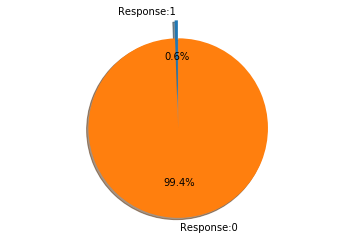

In [14]:
plt_pipe(counts_1_all_l[0].asDict())

In [14]:
counts_by_col = df_num2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
counts_by_col.limit(1).toPandas()

In [15]:
counts_by_col_l = counts_by_col.collect()

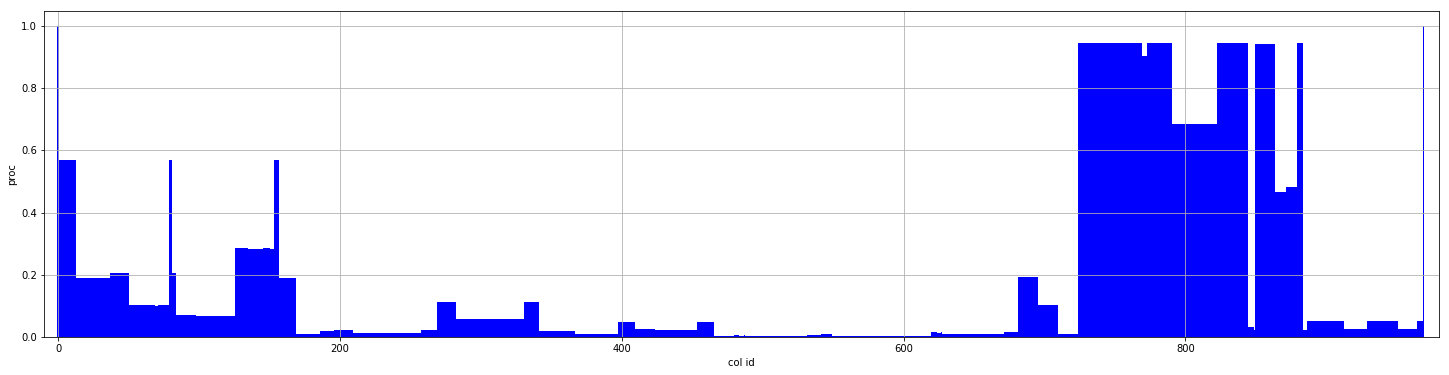

In [106]:
plt_hist(counts_by_col_l[0].asDict())

In [ ]:
col_with_resp = df_num2.filter(df_num2.Response == 1 ).select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
col_with_resp.limit(100).toPandas()

In [ ]:
col_with_resp_l = col_with_resp.collect()

In [ ]:
plt_hist(col_with_resp_l[0].asDict())

In [16]:
counts_by_col3 = df_date2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_date2.columns])

In [ ]:
counts_by_col3.limit(1).toPandas()

In [17]:
counts_by_col_l3 = counts_by_col3.collect()

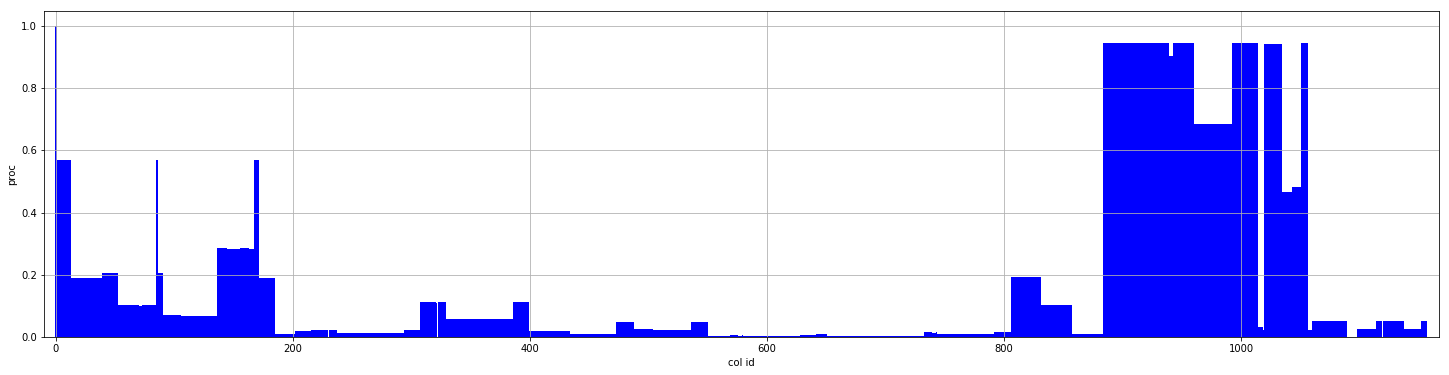

In [117]:
plt_hist(counts_by_col_l3[0].asDict())

In [18]:
counts_by_col4 = df_cat2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_cat2.columns])

In [19]:
counts_by_col_l4 = counts_by_col4.collect()

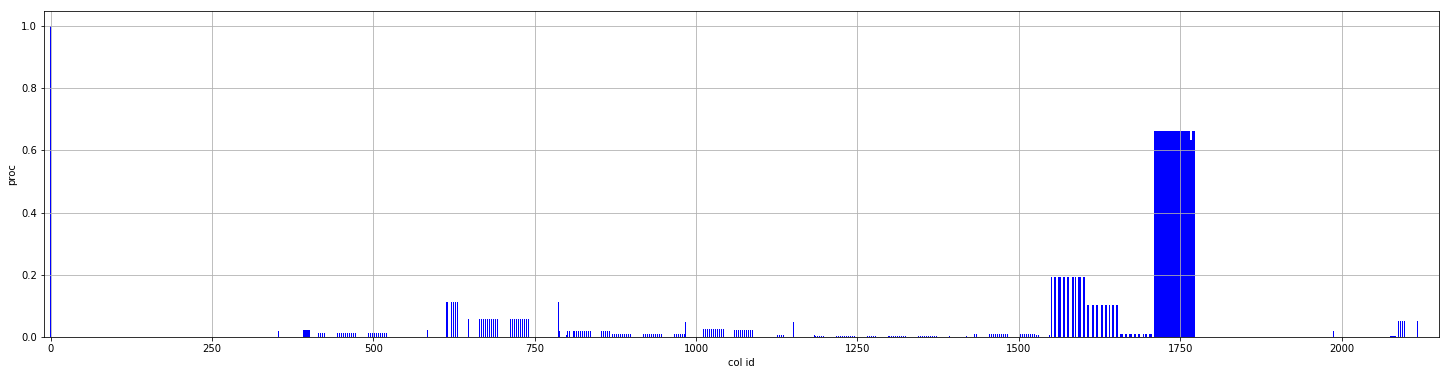

In [120]:
plt_hist(counts_by_col_l4[0].asDict())

In [19]:
# @jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf == 0:
        return 0
    else:
        return sup / np.sqrt(inf)


def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true)  # number of positive
    numn = n - nump  # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)

        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [23]:
df_date2 = df_date2.select("*",)

In [25]:
replace_cat_vals = F.udf(lambda val: 1 if val == 'T1' else 100, IntegerType())
flt_df_cat = flt_df_cat.select(flt_df_cat.Id, *[replace_cat_vals(c).alias(c) for c in flt_df_cat.columns if c != 'Id'])

In [26]:
flt_df_num = flt_df_num.na.fill(9999999)

In [27]:
flt_df_date = flt_df_date.na.fill(9999999)

In [28]:
full_df = flt_df_num.join(flt_df_date,flt_df_num.Id == flt_df_date.Id,'inner').drop(flt_df_date.Id)
full_df = full_df.join(flt_df_cat,full_df.Id == flt_df_cat.Id, 'inner').drop(flt_df_cat.Id)

In [29]:
full_df.write.csv('{0}/{1}'.format(dir_name,'full_df.csv'),sep=',',header=True,quote='')

In [31]:
full_df2 = sqlContext.read.csv('{0}/{1}'.format(dir_name,'full_df.csv'), sep=',', header=True, inferSchema=True)

### Creation of Models 

In [32]:
full_df3 = full_df2

In [20]:
from pyspark.ml.classification import GBTClassifier,RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,PCA

In [35]:
features = [c for c in full_df3.columns if c != 'Id' and c != 'Response']

In [36]:
vecAssembler = VectorAssembler(inputCols=features, outputCol="features")

In [37]:
%%time
ass = vecAssembler.transform(full_df3)

CPU times: user 44 ms, sys: 16 ms, total: 60 ms
Wall time: 1.04 s


In [38]:
assd = ass.select(['Id','Response','features']).drop()

In [39]:
assd.limit(5).toPandas()
#assd.printSchema()

,Id,Response,features
0,616,0,"[9999999.0, 9999999.0, 0.0, 9999999.0, 0.071, ..."
1,632,0,"[9999999.0, 9999999.0, 0.0, 9999999.0, -0.003,..."
2,681,0,"[9999999.0, 9999999.0, 9999999.0, 9999999.0, 9..."
3,1392,0,"[9999999.0, 9999999.0, 0.0, 9999999.0, -0.041,..."
4,1526,0,"[9999999.0, -0.06, 0.0, -0.048, 0.071, 0.0, 99..."


In [89]:
selector = PCA(inputCol="features",outputCol="pca_features",k=150)
selectorModel = selector.fit(assd)

In [95]:
assd_pca = selectorModel.transform(assd)

In [96]:
assd_pca = assd_pca.select(assd_pca.Id,assd_pca.Response,assd_pca.pca_features.alias('features'))

In [97]:
assd_pca.limit(10).toPandas()

,Id,Response,features
0,616,0,"[-14800141.0267, -11850196.7376, -15041527.337..."
1,632,0,"[-60212203.2331, -1938971.22418, -62560141.312..."
2,681,0,"[-185774626.071, 34756944.3064, 6541367.92099,..."
3,1392,0,"[-14638198.0166, -11615436.458, -14983852.8253..."
4,1526,0,"[-55103249.0212, 1036295.53263, 41394941.224, ..."
5,2063,0,"[-54752882.5812, 1278373.30855, 41453234.3806,..."
6,2423,0,"[-88364506.52, 94931875.8661, -25848100.0669, ..."
7,2621,0,"[21750591.8206, 79928918.9989, 575880.453382, ..."
8,3464,0,"[21574524.0218, 79897548.2899, 617134.480183, ..."
9,3554,0,"[-60363752.6437, -1971104.02712, -62507128.792..."


In [114]:
assd0 = assd_pca.filter(assd.Response == 0).sample(False, 0.006,43)

In [115]:
assd1 = assd_pca.filter(assd.Response == 1)

In [116]:
assd_n = assd0.union(assd1)

In [117]:
assd_pca.limit(10).toPandas()

,Id,Response,features
0,616,0,"[-14800141.0267, -11850196.7376, -15041527.337..."
1,632,0,"[-60212203.2331, -1938971.22418, -62560141.312..."
2,681,0,"[-185774626.071, 34756944.3064, 6541367.92099,..."
3,1392,0,"[-14638198.0166, -11615436.458, -14983852.8253..."
4,1526,0,"[-55103249.0212, 1036295.53263, 41394941.224, ..."
5,2063,0,"[-54752882.5812, 1278373.30855, 41453234.3806,..."
6,2423,0,"[-88364506.52, 94931875.8661, -25848100.0669, ..."
7,2621,0,"[21750591.8206, 79928918.9989, 575880.453382, ..."
8,3464,0,"[21574524.0218, 79897548.2899, 617134.480183, ..."
9,3554,0,"[-60363752.6437, -1971104.02712, -62507128.792..."


In [118]:
tr_dt,tst_dt = assd_pca.randomSplit([0.7,0.3])

In [119]:
rfc = RandomForestClassifier(numTrees=50, maxDepth=5, labelCol="Response", seed=201)

In [125]:
tr_dt.show()

+----+--------+--------------------+
|  Id|Response|            features|
+----+--------+--------------------+
| 221|       0|[-4.2616456197303...|
| 662|       0|[-2484159.9136024...|
| 835|       0|[-4.2615926488981...|
|1222|       0|[-1.4813420789474...|
|1225|       0|[-4.2791575362666...|
|1237|       0|[-1.8386202558379...|
|1392|       0|[-1.4638198016554...|
|1895|       0|[-6.0360067469398...|
|2063|       0|[-5.4752882581227...|
|2131|       0|[-1.8562938191507...|
|2184|       0|[-1.4804746431321...|
|2421|       0|[2.17475455652968...|
|2423|       0|[-8.8364506519994...|
|2621|       0|[2.17505918205811...|
|2891|       0|[-4.2797199445829...|
|2984|       0|[-1.8564875119256...|
|2987|       0|[-5.4890358987665...|
|3082|       0|[-4.2793724474984...|
|3181|       0|[-5.4936057598429...|
|3345|       0|[-5.4953494453717...|
+----+--------+--------------------+
only showing top 20 rows



In [120]:
%%time
model = rfc.fit(tr_dt)

CPU times: user 120 ms, sys: 8 ms, total: 128 ms
Wall time: 17min 14s


In [60]:
l = [(k,v) for k,v in enumerate(fti)]
ls = sorted(l,key= lambda r:r[1],reverse=True)
ls

[(364, 0.080267763500573408),
 (262, 0.069949887230022031),
 (115, 0.053014215830289868),
 (52, 0.043871341695302407),
 (87, 0.041532406895582907),
 (319, 0.041247726876347292),
 (136, 0.040613562023527415),
 (191, 0.032540378309814093),
 (292, 0.030011212629576345),
 (65, 0.028618167872538562),
 (88, 0.027745305876811264),
 (211, 0.027658978549798312),
 (209, 0.025916674650908883),
 (46, 0.024709042362487145),
 (202, 0.024681375148027231),
 (95, 0.023800403087806121),
 (237, 0.021274106213524168),
 (98, 0.020735794875357795),
 (86, 0.019340084386997327),
 (239, 0.018645568324960279),
 (147, 0.018303068476105213),
 (199, 0.017624475104911955),
 (220, 0.015267234878887537),
 (201, 0.015129852220690052),
 (230, 0.01437355179496767),
 (7, 0.014180281607633615),
 (155, 0.014134699071071588),
 (58, 0.013470269195850095),
 (20, 0.013443302850563903),
 (29, 0.012851967770313071),
 (159, 0.012233768998858002),
 (157, 0.011843588951752537),
 (45, 0.011717003135869854),
 (268, 0.0114124740239315

In [121]:
pr = model.transform(tst_dt)

In [122]:
pr.show()

+----+--------+--------------------+--------------------+--------------------+----------+
|  Id|Response|            features|       rawPrediction|         probability|prediction|
+----+--------+--------------------+--------------------+--------------------+----------+
| 265|       0|[-5.5059986706710...|[49.8413286444144...|[0.99682657288828...|       0.0|
| 407|       0|[-4.8227132773116...|[49.7106245438695...|[0.99421249087739...|       0.0|
| 457|       0|[7196744.98570346...|[49.7202634067274...|[0.99440526813454...|       0.0|
| 616|       0|[-1.4800141026705...|[49.8415091399721...|[0.99683018279944...|       0.0|
| 632|       0|[-6.0212203233109...|[49.7191910609986...|[0.99438382121997...|       0.0|
| 681|       0|[-1.8577462607146...|[49.7520178860112...|[0.99504035772022...|       0.0|
|1526|       0|[-5.5103249021181...|[49.8344698395687...|[0.99668939679137...|       0.0|
|1603|       0|[-2658693.2143116...|[49.8262998895224...|[0.99652599779044...|       0.0|
|2460|    

In [123]:
label_pred_list = pr.select(pr['Response'],pr['prediction']).collect()

### Testing Models

### Results evaluation

In [109]:
def matthews_corr_coef(label_pred_list): 
    import math
    tp = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 1)
    tn = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 0)
    fp = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 1)
    fn = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 0)
    print "True Positives:", tp
    print "True Negatives:", tn
    print "False Positives:", fp
    print "False Negatives:", fn
    #print "Total", df.count()
    try:
        MCC = ((tp * tn) - (fp * fn)) / math.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    except ZeroDivisionError:
        MCC = -1
    print "Matthews correlation coefficient: ", MCC

In [124]:
matthews_corr_coef(label_pred_list)

True Positives: 0
True Negatives: 353672
False Positives: 0
False Negatives: 2041
Matthews correlation coefficient:  -1
